In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [78]:
import os
import glob
import random

In [79]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Rescaling, Resizing, Flatten, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
tf.keras.utils.set_random_seed(111)

## Data Preprocessing

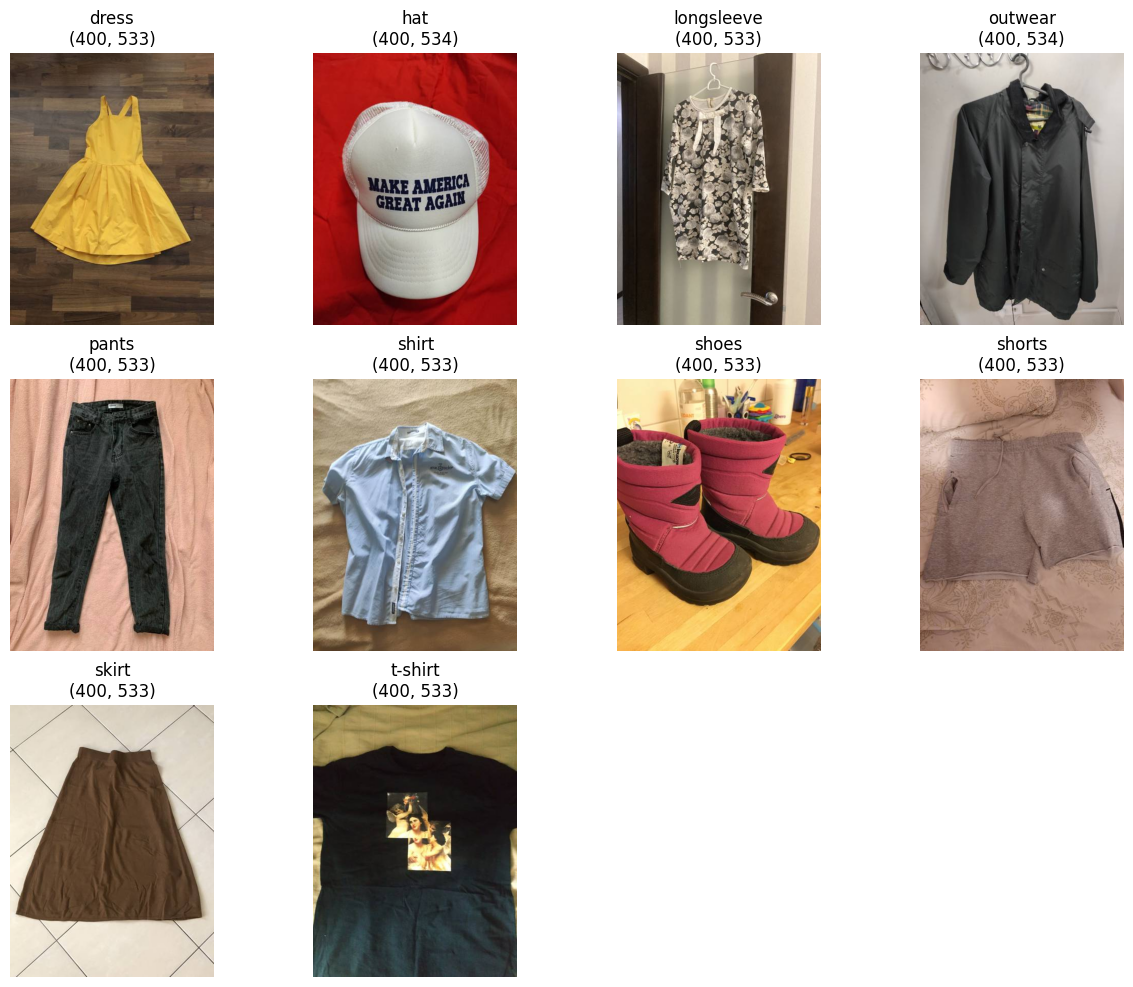

In [80]:
class_dirs = os.listdir("clothing-dataset-small/train")
image_dict = {} 
count_dict = {}

for cls in class_dirs:
    # Use glob to get all files inside the specific class folder
    file_paths = glob.glob(f'clothing-dataset-small/train/{cls}/*')
    
    if file_paths: # Check if folder isn't empty
        count_dict[cls] = len(file_paths)
        image_path = random.choice(file_paths)
        image_dict[cls] = tf.keras.utils.load_img(image_path)
        
plt.figure(figsize=(15, 12))
for i, (cls, img) in enumerate(image_dict.items()):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f'{cls}\n{img.size}')
    plt.axis("off")
plt.show()

Count of training samples per class:
         class  count
9     t-shirt    795
4       pants    468
2  longsleeve    455
5       shirt    290
0       dress    241
7      shorts    202
6       shoes    198
3     outwear    184
1         hat    123
8       skirt    112


<Axes: title={'center': 'Training Data Count per class'}, xlabel='class'>

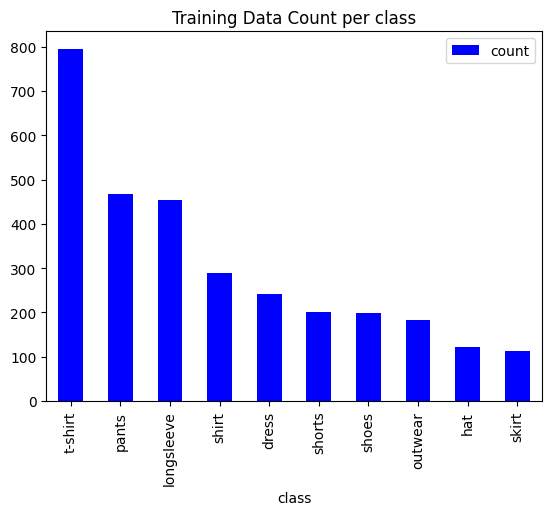

In [81]:
## Plot of the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     
    "count": count_dict.values(),   
}).sort_values(by="count", ascending=False)

print("Count of training samples per class:\n", df_count_train)

df_count_train.plot.bar(
    x='class', 
    y='count', 
    title="Training Data Count per class",color="blue")

In [82]:
print('\nLoading Train Data')
train_data = tf.keras.utils.image_dataset_from_directory("clothing-dataset-small/train", shuffle = True,)

print('\nLoading Validation Data')
val_data = tf.keras.utils.image_dataset_from_directory("clothing-dataset-small/validation", shuffle = False,)

print('\nLoading Test Data')
test_data = tf.keras.utils.image_dataset_from_directory("clothing-dataset-small/test", shuffle = False,)


Loading Train Data
Found 3068 files belonging to 10 classes.

Loading Validation Data
Found 341 files belonging to 10 classes.

Loading Test Data
Found 372 files belonging to 10 classes.


In [83]:
# Data Processing Stage with resizing and rescaling operations
def preprocess(train_data, val_data, test_data, target_height=128, target_width=128):
    data_preprocess = keras.Sequential(
        name="data_preprocess",
        layers=[
            layers.Resizing(target_height, target_width),
            layers.Rescaling(1.0/255),]
    )
    train_ds = train_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

In [84]:
train_ds, val_ds, test_ds = preprocess(train_data, val_data, test_data)

In [85]:
def arch_1(height=128, width=128):
    num_classes = 10
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn_1",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same", activation='relu'),
            # layers.MaxPooling2D(),
            # layers.Flatten(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size, activation='relu'),
            layers.Dense(units=num_classes, activation='softmax')
        ])
    return model

In [86]:
model = arch_1()
model.summary()

Model: "model_cnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 16, 16, 64)       

In [87]:
def compile_train_v1(model, train_ds, val_ds, ckpt_path="model_checkpoint.weights.h5",epochs = 10):
    epochs = 20
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[keras.callbacks.ModelCheckpoint(
                ckpt_path,
                save_weights_only=True,
                monitor='val_accuracy',
                mode='max',
                save_best_only=True
            )])
    return model_fit

In [88]:
model_fit = compile_train_v1(model, train_ds, val_ds)

Epoch 1/20
96/96 [==============================] - 15s 155ms/step - loss: 2.1421 - accuracy: 0.2581 - val_loss: 2.1812 - val_accuracy: 0.2375
Epoch 2/20
96/96 [==============================] - 15s 154ms/step - loss: 2.0432 - accuracy: 0.2999 - val_loss: 2.1504 - val_accuracy: 0.2669
Epoch 3/20
96/96 [==============================] - 14s 148ms/step - loss: 1.8747 - accuracy: 0.3641 - val_loss: 1.9701 - val_accuracy: 0.3343
Epoch 4/20
96/96 [==============================] - 17s 180ms/step - loss: 1.8117 - accuracy: 0.3849 - val_loss: 1.8662 - val_accuracy: 0.3695
Epoch 5/20
96/96 [==============================] - 16s 161ms/step - loss: 1.6776 - accuracy: 0.4316 - val_loss: 1.7479 - val_accuracy: 0.3842
Epoch 6/20
96/96 [==============================] - 16s 163ms/step - loss: 1.5302 - accuracy: 0.4759 - val_loss: 1.6619 - val_accuracy: 0.4370
Epoch 7/20
96/96 [==============================] - 16s 164ms/step - loss: 1.4159 - accuracy: 0.5271 - val_loss: 1.5864 - val_accuracy: 0.4457

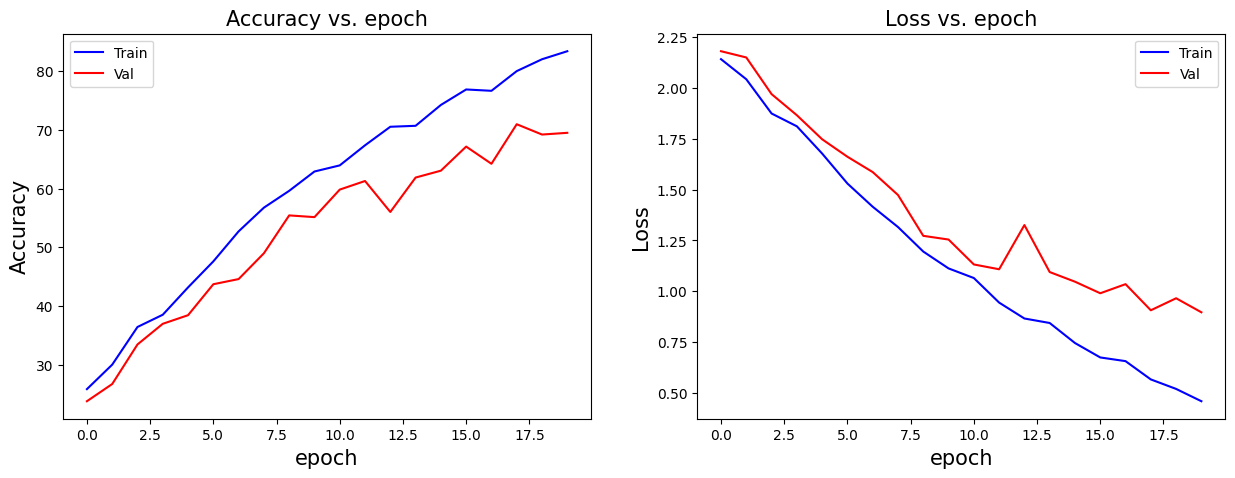

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax = axes.ravel()

# Accuracy graph
ax[0].plot(range(0,model_fit.params['epochs']), [acc * 100 for acc in model_fit.history['accuracy']], label='Train', color='b')
ax[0].plot(range(0,model_fit.params['epochs']), [acc * 100 for acc in model_fit.history['val_accuracy']], label='Val', color='r')
ax[0].set_title('Accuracy vs. epoch', fontsize=15)
ax[0].set_ylabel('Accuracy', fontsize=15)
ax[0].set_xlabel('epoch', fontsize=15)
ax[0].legend()

# loss graph
ax[1].plot(range(0,model_fit.params['epochs']), model_fit.history['loss'], label='Train', color='b')
ax[1].plot(range(0,model_fit.params['epochs']), model_fit.history['val_loss'], label='Val', color='r')
ax[1].set_title('Loss vs. epoch', fontsize=15)
ax[1].set_ylabel('Loss', fontsize=15)
ax[1].set_xlabel('epoch', fontsize=15)
ax[1].legend()
plt.show()

In [90]:
from sklearn.metrics import accuracy_score, confusion_matrix

true_categories = tf.concat([y for x, y in test_ds], axis=0)
images = tf.concat([x for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
class_names = test_data.class_names
predicted_categories = tf.argmax(y_pred, axis=1)

test_acc = accuracy_score(true_categories, predicted_categories) * 100
print(f'\nTest Accuracy: {test_acc:.2f}%\n')

12/12 [==============================] - 1s 43ms/step

Test Accuracy: 65.86%



12/12 [==============================] - 1s 42ms/step


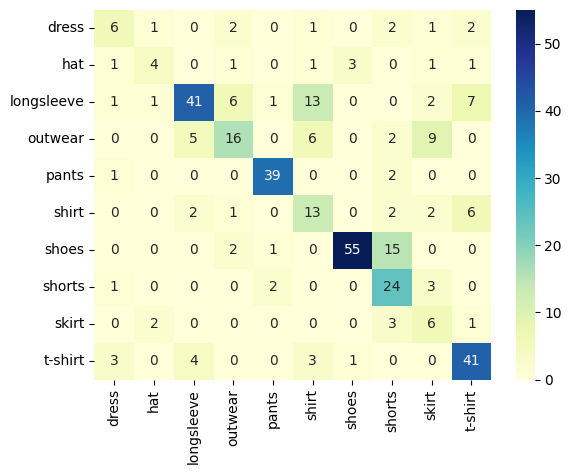

In [91]:
def ConfusionMatrix(model, ds, label_list):
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in ds], axis=0)
    cm = confusion_matrix(true_categories,predicted_categories) # last batch
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()

ConfusionMatrix(model, test_ds, test_data.class_names)

In [92]:
# function to plot image given image, its true label and class probabilities (pred_array)
def plot_image(pred_array, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(pred_array),
                                class_names[true_label]),
                                color=color)

# function to plot barplot of class probabilities (pred_array)
def plot_value_array(pred_array, true_label):
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), pred_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(pred_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('green')

12/12 [==============================] - 1s 43ms/step


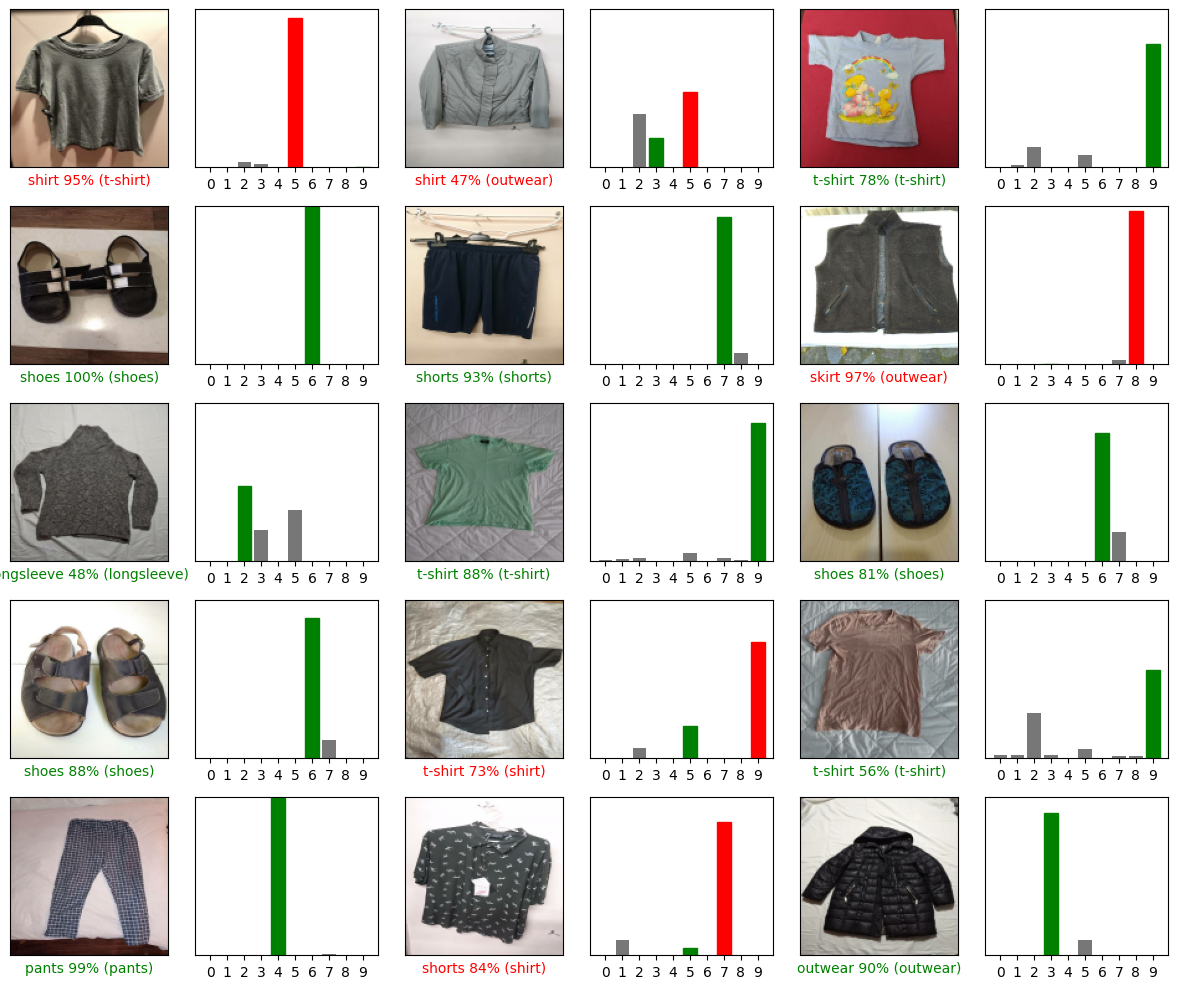

In [93]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)
images = tf.concat([x for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
class_names = test_data.class_names

# Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
indices = random.sample(range(len(images)), 15)
# Color correct predictions in green and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i,index in enumerate(indices):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(y_pred[index], true_categories[index], images[index])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(y_pred[index], true_categories[index])
plt.tight_layout()
plt.show()


### Fine tuning Hyperparameters

- By adding Maxpool2D layer, BatchNormalization, GlobalAveragepooling2D instead of Dense and Flatten layer, addition of dropout layer. 

In [94]:
def arch_2(height=128, width=128):
    num_classes = 10
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn_2",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", input_shape=(height, width, 3),
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),

            layers.Conv2D(filters=32, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),

            layers.Conv2D(filters=64, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),

            layers.Conv2D(filters=128, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),

            layers.Conv2D(filters=256, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size, kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [95]:
model = arch_2()
model.summary()

Model: "model_cnn_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 activation_30 (Activation)  (None, 128, 128, 16)      0         
                                                                 
 batch_normalization_30 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 activation_31 (Activation)  (None, 64, 64, 32)        

In [99]:
def compile_train_v2(model, train_ds, val_ds, epochs=10, ckpt_path="model_checkpoint.weights.h5"):
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=5, min_lr=0.00001),

        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),

        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, min_delta=0.001, mode='min')
    ]
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    return model_fit

In [102]:
model = arch_2()
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
96/96 [==============================] - 23s 226ms/step - loss: 3.3407 - accuracy: 0.2360 - val_loss: 3.1687 - val_accuracy: 0.2375 - lr: 0.0010
Epoch 2/100
96/96 [==============================] - 32s 333ms/step - loss: 2.6983 - accuracy: 0.3595 - val_loss: 4.5758 - val_accuracy: 0.2375 - lr: 0.0010
Epoch 3/100
96/96 [==============================] - 61s 630ms/step - loss: 2.4777 - accuracy: 0.4130 - val_loss: 2.9118 - val_accuracy: 0.2991 - lr: 0.0010
Epoch 4/100
96/96 [==============================] - 62s 639ms/step - loss: 2.2097 - accuracy: 0.4967 - val_loss: 2.5884 - val_accuracy: 0.3548 - lr: 0.0010
Epoch 5/100
96/96 [==============================] - 61s 622ms/step - loss: 1.9777 - accuracy: 0.5440 - val_loss: 2.1621 - val_accuracy: 0.4487 - lr: 0.0010
Epoch 6/100
96/96 [==============================] - 60s 618ms/step - loss: 1.7934 - accuracy: 0.5978 - val_loss: 1.9332 - val_accuracy: 0.5279 - lr: 0.0010
Epoch 7/100
96/96 [==============================] - 20s 2

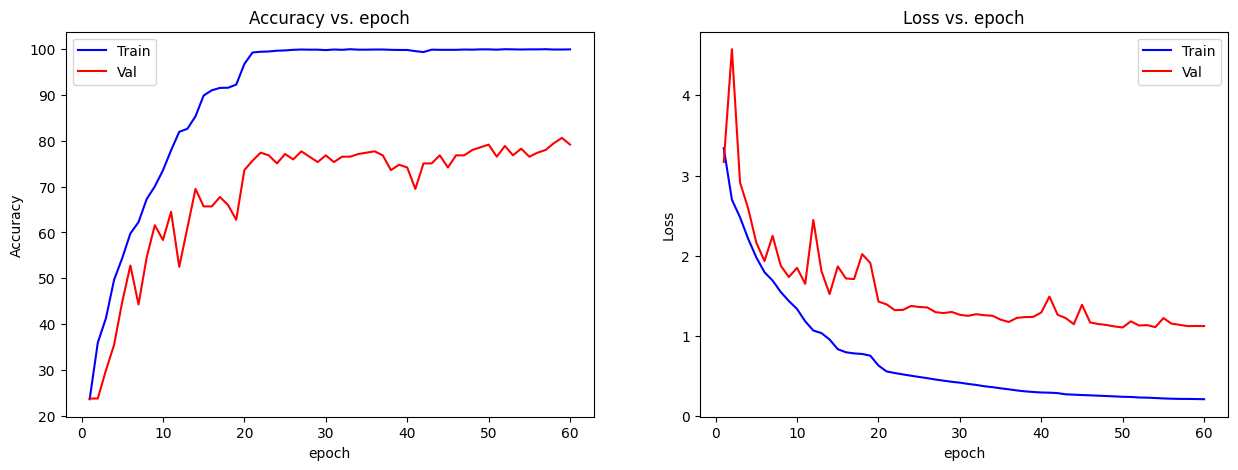

In [115]:
from sklearn.metrics import classification_report
def plot_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(epochs, [a * 100 for a in history.history['accuracy']], label='Train', color='b')
    if 'val_accuracy' in history.history:
        ax[0].plot(epochs, [a * 100 for a in history.history['val_accuracy']], label='Val', color='r')
    ax[0].set_title('Accuracy vs. epoch'); ax[0].set_xlabel('epoch'); ax[0].set_ylabel('Accuracy'); ax[0].legend()

    ax[1].plot(epochs, history.history['loss'], label='Train', color='b')
    if 'val_loss' in history.history:
        ax[1].plot(epochs, history.history['val_loss'], label='Val', color='r')
    ax[1].set_title('Loss vs. epoch'); ax[1].set_xlabel('epoch'); ax[1].set_ylabel('Loss'); ax[1].legend()
    plt.show()
plot_history(model_fit)


In [108]:
from sklearn.metrics import accuracy_score, confusion_matrix

true_categories = tf.concat([y for x, y in test_ds], axis=0)
images = tf.concat([x for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
class_names = test_data.class_names
predicted_categories = tf.argmax(y_pred, axis=1)

test_acc = accuracy_score(true_categories, predicted_categories) * 100
print(f'\nTest Accuracy: {test_acc:.2f}%\n')

12/12 [==============================] - 1s 61ms/step

Test Accuracy: 74.46%



12/12 [==============================] - 1s 65ms/step


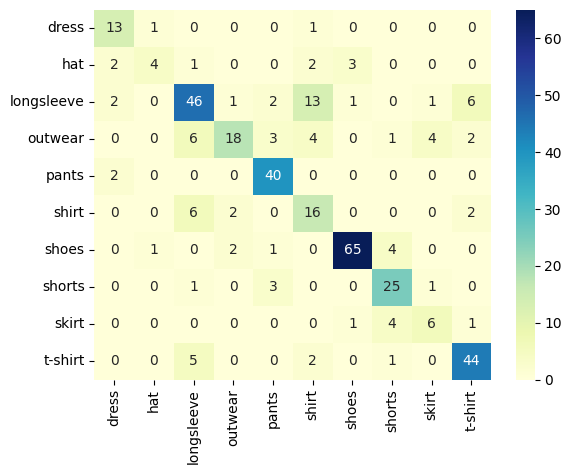

In [109]:
def ConfusionMatrix(model, ds, label_list):
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in ds], axis=0)
    cm = confusion_matrix(true_categories,predicted_categories) # last batch
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()

ConfusionMatrix(model, test_ds, test_data.class_names)

12/12 [==============================] - 1s 60ms/step


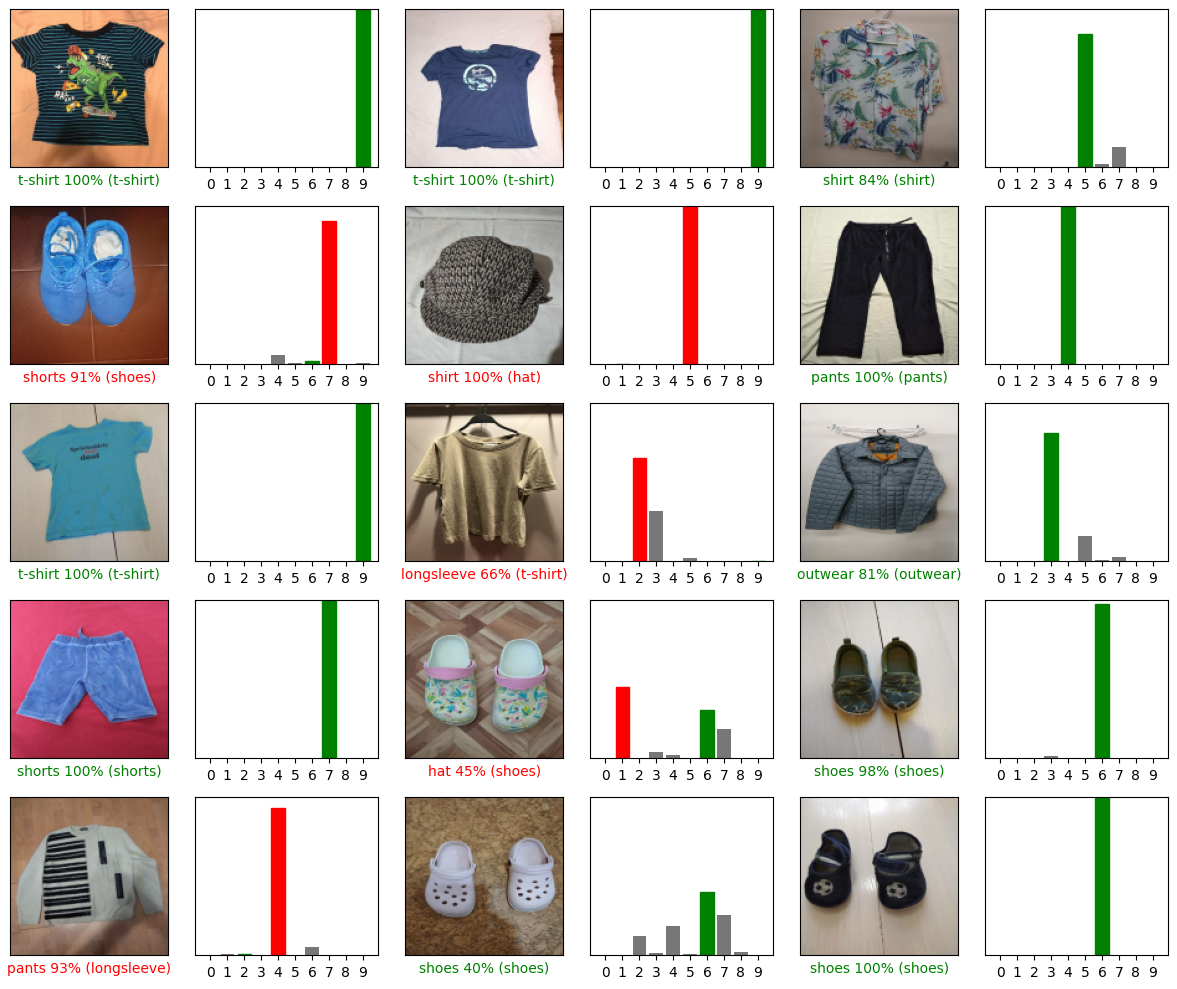

In [111]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)
images = tf.concat([x for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
class_names = test_data.class_names

# Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
indices = random.sample(range(len(images)), 15)
# Color correct predictions in green and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i,index in enumerate(indices):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(y_pred[index], true_categories[index], images[index])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(y_pred[index], true_categories[index])
plt.tight_layout()
plt.show()

In [121]:
def pixel_range(image):
    arr = image
    if isinstance(arr, tf.Tensor):
        arr = arr.numpy()
    arr = np.asarray(arr)
    return np.min(arr), np.max(arr), np.max(arr) - np.min(arr)

print("PIL img (uint8):", pixel_range(img))
print("single tensor image (normalized 0-1):", pixel_range(images[0]))
print("all images tensor (normalized 0-1):", pixel_range(images))

PIL img (uint8): (0, 255, 255)
single tensor image (normalized 0-1): (0.00080021884, 0.900643, 0.8998428)
all images tensor (normalized 0-1): (0.0, 1.0, 1.0)


In [ ]:
# To Get the global range (all channels combined)
min_val = np.min(images)
max_val = np.max(images)

# To Get the range per channel (B, G, R)
min_per_ch = np.min(images, axis=(0, 1))
max_per_ch = np.max(images, axis=(0, 1))

print(f"Global Pixel Range: {min_val} to {max_val}")
print(f"Blue Channel Range:  {min_per_ch[0]} to {max_per_ch[0]}")
print(f"Green Channel Range: {min_per_ch[1]} to {max_per_ch[1]}")
print(f"Red Channel Range:   {min_per_ch[2]} to {max_per_ch[2]}")